# Rasters in Python Tutorial
Utilizing Python library rasterio

Raster file types:
- .bil
- .tif

## Resources

Rasterio
<br>https://rasterio.readthedocs.io/en/latest/
<br>https://rasterio.readthedocs.io/en/latest/quickstart.html#

Raster of NLCD Land Cover, New York, 2016
<br>https://cugir.library.cornell.edu/catalog/cugir-009031

## Libraries

In [1]:
import rasterio as rio
import rasterio.features
import rasterio.warp
import numpy as np
import os, glob

from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib import pyplot

%matplotlib inline

## Extracts GeoJSON from a raster

Since the raster is larger, run jupyter notebook command as:
<br>jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

In [2]:
raster_path = 'NYC/raster/nlcd2016_ny.tif'

In [3]:
with rio.open(raster_path) as dataset:
    
    # Read the dataset's valid data mask as a ndarray.
    # image dtype must be one of: int16, int32, uint8, uint16, float32
    mask = dataset.dataset_mask().astype('float32')

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        #print(geom)
        
    # Partially printing due to large amount of data
    print("Type: {}".format(geom["type"]))
    print("Coordinate 0: {}".format(geom["coordinates"][0][0]))

Type: Polygon
Coordinate 0: [-78.939649, 45.847774]


{'init': 'epsg:5070'}
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


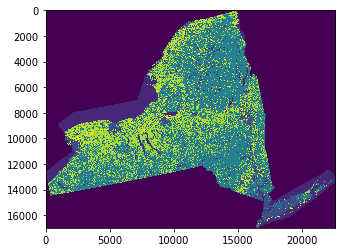

In [4]:
# Open the raster
with rio.open(raster_path) as dataset:
    
    # Print coordinate system
    print(dataset.crs.data)
    
    #Print actual raster data
    print(dataset.read())
    
    # Visualize data as map
    # Note: you can enter a number in read(), and it selects which band to use in raster
    # Typically there's only one band, but not always
    pyplot.imshow(dataset.read(1))
    pyplot.show()

Further reading: 
    
http://help.arcgis.com/en/geodatabase/10.0/sdk/arcsde/concepts/rasters/entities/rasterbands.htm


## Transform bounds

In [5]:
with rio.open(raster_path) as dataset:
    print("Original crs: {}".format(dataset.crs.data))
    print("Original bounds: {}".format(dataset.bounds))
    west, south, east, north = rasterio.warp.transform_bounds(dataset.crs.data,
                                                             {'init': 'EPSG:4326'},
                                                             dataset.bounds[0], dataset.bounds[1],
                                                             dataset.bounds[2], dataset.bounds[3])
    print("Transformed bounds: {}, {}, {}, {}".format(west, south, east, north))

Original crs: {'init': 'epsg:5070'}
Original bounds: BoundingBox(left=1319355.0, bottom=2149035.0, right=1997655.0, top=2658705.0)
Transformed bounds: -80.0356743506, 40.086401314, -70.5164599533, 45.8477741111


## Reproject Raster to new CRS

In [6]:
dst_crs = 'EPSG:4326'

with rio.open(raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    print("Original crs: {}".format(src.crs.data))

    with rio.open('NYC/raster/transformed.bil', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
        print("Reprojected crs: {}".format(dst.crs.data))

Original crs: {'init': 'epsg:5070'}
Reprojected crs: {'init': 'epsg:4326'}


In [7]:
for filename in glob.glob("./NYC/raster/transformed*"):
    print(filename)
    os.remove(filename)

./NYC/raster/transformed.bil


## Masking and Clipping a Raster

Utilizes geopandas and shapely's function 'box'
- 'box' is simply a four sided vector Polygon

https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html